In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 데이터 생성

$$\begin{aligned}
\text{model function}&: y(x, \mathbf{w}) = w_0 + w_1 x\\
\text{real function} &: f(x, \mathbf{a}) = a_0 + a_1 x +\eta
\end{aligned}$$

$$\begin{aligned}
x_n &\sim U(x \vert -1, 1) \\
t_n &= f(x, \mathbf{a}) = a_0 + a_1 x +\eta\\
\quad& \eta \sim \mathcal{N}(0, sigma^2), \quad \text{where }\sigma=0.2 \\
\quad& a = (a_0, a_1) = (-0.3, 0.5) \\
\end{aligned}$$

* purpose: given $\beta = \sigma^{-2} = 25$, calculate $w$

x = 
[-0.69 -0.4  -0.88 -0.08  0.67  0.85  0.45  0.54 -0.46  0.29 -0.81 -0.84
  0.18 -0.31  0.98  0.25  0.36  0.1  -0.46 -0.25]
t = 
[-0.67 -0.52 -0.79 -0.36  0.07  0.14 -0.13 -0.   -0.51 -0.17 -0.7  -0.78
 -0.11 -0.44  0.18 -0.17 -0.08 -0.25 -0.55 -0.41]


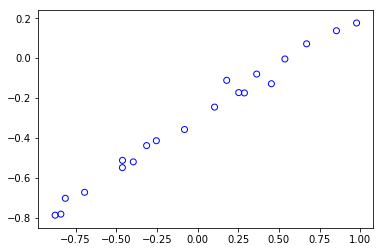

In [13]:
np.random.seed(777)
N = 20  # data points
a = np.array([-0.3, 0.5])  # the real weight
def target_function(x, a, add=True):
    """
    **only support single variable**
    function: f(x, a)
    add: if x doesn't contain 1 vector for bias term, 
         automatically create it
    """
    N = x.shape[0]
    if add:
        x = np.vander(x, N=2, increasing=True)  # (N, 2)

    eta = np.random.normal(scale=0.2**2, size=(N,))
    return x.dot(a) + eta

x = np.random.uniform(low=-1, high=1, size=(N,))
t = target_function(x, a, add=True)
print(f"x = \n{x.round(2)}")
print(f"t = \n{t.round(2)}")
plt.scatter(x, t, edgecolors="b", facecolors="none", marker="o")
plt.show()

## 사전 켤례 분포(Congungate Prior):

$p(\mathbf{w}) = \mathcal{N}(\mathbf{w} \vert m_0, S_0)$

* $n=0$ 아직 데이터가 주어지지 않았을 때, $m_0$: 평균, $S_0$: 공분산

## 사후 분포(Posterior)

$p(\mathbf{w} \vert \mathbf{t}) = \mathcal{N}(\mathbf{w} \vert m_N, S_N)$

* $n=N$ 데이터를 전부 사용한 경우, $m_N$: 평균, $S_N$: 분산

* 평균과 분산을 구하는 과정
$\begin{aligned}m_N &= S_N(S_0^{-1}m_0 + \beta\Phi^T\mathbf{t})\\
S_N^{-1} &= S_0^{-1} + \beta \Phi^T\Phi\end{aligned}$

* http://www.cs.utoronto.ca/~radford/csc2541.S11/week6.pdf

* Simplify

$$p(\mathbf{w} \vert \alpha) = \mathcal{N}(\mathbf{w}\vert 0, \alpha^{-1}\mathbf{I}) \\
\downarrow \\
\begin{aligned}m_N &= \beta S_N\Phi^T\mathbf{t}\\
S_N^{-1} &= \alpha\mathbf{I}+\beta \Phi^T\Phi\end{aligned}$$

In [3]:
def Gaussian(x, mean, cov):
    """
    x : last dimension must be number of variable demension (*batch, 1, D), D is dimension of random variable x
        For instance 1-D shape should be (N, 1, 1)
        support if `x.ndim == 1` automatically change to (batch, 1, 1)
    mean : D-dimension mean vector
    cov : covariance
    """
    assert isinstance(x, np.ndarray), "input must be np.ndarray"
    # change dimension for 1-D array
    if x.ndim == 1:
        x = x.reshape(x.size, 1, 1)
        if not isinstance(cov, np.ndarray):
            cov = np.array([[cov]])
        elif (cov.ndim == 1):
            cov = cov.reshape(1, 1)
    assert x.shape[-2] == 1, "must be a row vector, so x.shape[-2]==1"
    D = x.shape[-1]
    N_dims = len(x.shape)
    # mahalanobis distance: \Delta^2
    trans_axes = list(range(N_dims-2)) + [N_dims-1, N_dims-2]
    distance = np.squeeze((1/2)*np.matmul((x - mean).dot(np.linalg.inv(cov)), np.transpose((x - mean), axes=trans_axes)))
    return (2*np.pi)**(-D/2)*np.linalg.det(cov)**(-1/2)*np.exp(-distance)

In [4]:
sigma = 0.2
alpha = 2.0
beta = 1/sigma**2

def Posterior_mu(x, cov, t, alpha, beta):
    # Phi
    V = np.vander(x, N=2, increasing=True)
    return beta*cov.dot(V.T).dot(t)

def Posterior_cov(x, alpha, beta):
    # Phi
    V = np.vander(x, N=2, increasing=True)
    covinv = alpha*np.eye(2) + beta*V.T.dot(V)
    return np.linalg.inv(covinv)

In [5]:
from matplotlib import cm

# Prior 
ws = np.linspace(-1, 1, 100)
wx, wy = np.meshgrid(ws, ws)
X = np.dstack([wx, wy])[:, :, np.newaxis]
prior_g = Gaussian(X, mean=np.zeros(2), cov=alpha**(-1)*np.eye(2))

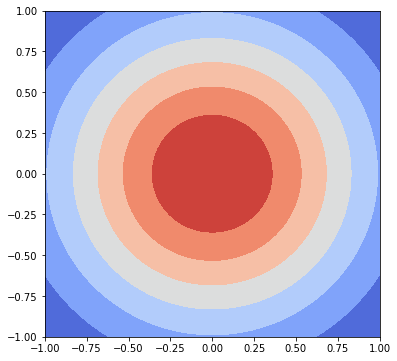

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cset = ax.contourf(wx, wy, prior_g, cmap=cm.coolwarm)
plt.show()

In [16]:
cov_post = Posterior_cov(x, alpha, beta)
mu_post = Posterior_mu(x, cov_post, t, alpha, beta)
posterior_g = Gaussian(np.dstack([wx, wy])[:, :, np.newaxis], 
                   mean=mu_post, cov=cov_post)

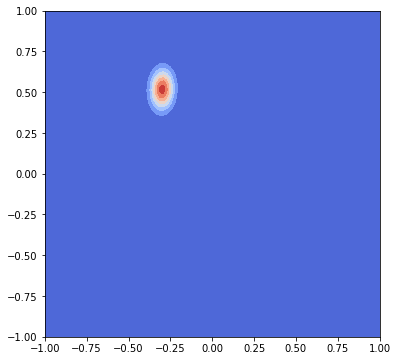

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cset = ax.contourf(wx, wy, posterior_g, cmap=cm.coolwarm)
plt.show()

* Likelihood

$$p(\mathbf{t} \vert \mathbf{w}) = \dfrac{1}{(2\pi\sigma^2)^{1/2}}\exp \Big\{ -\dfrac{1}{2\sigma^2}(t \Big\}$$